# **구글 연동**

In [1]:
# Google Drive 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **폰트 설치**


In [2]:
# 구글 코랩에서 한글 폰트를 설치합니다.
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치된 폰트를 확인합니다.
!fc-list :lang=ko

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Bold,나눔스퀘어라운드 Bold:style=Bold,Regular
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf: NanumGothicCoding,나눔고딕코딩:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Regular,나눔스퀘어라운드 Regular:style=Regular
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf: NanumSquare,나눔스퀘어,NanumSquare Bold,나눔스퀘어 Bold:style=Bold
/usr/share/fo

# **모델별 예측 성능 (훈련 데이터 기반)**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# CSV 파일 불러오기(실제 별점 포함)
data = pd.read_csv("finetuned_sentiment_results.csv")

# 특성(X)과 타겟(y) 설정
X = data[['긍정비율', '부정비율']]
y = data['실제별점']  # 모델이 예측할 별점 (훈련용)

# 학습 데이터 분리(train-test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 데이터 정규화 (LSTM을 위해 MinMax Scaling 적용)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM 입력 형태 변환
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# LSTM 모델 구성 - 기본 Dropout 적용
# LSTM MSE: 0.0377, RMSE: 0.1942, R²: 0.1501
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# # 모델 컴파일 (학습 전에 수행)
# LSTM MSE: 0.0377, RMSE: 0.1942, R²: 0.1501
lstm_model.compile(optimizer='adam', loss='mse')

# EarlyStopping 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# LSTM 모델 학습 (EarlyStopping 적용)
# 모델 성능 높이기 - 배치크기 조정,  에포크 수 up -> 과적합 방지를 위해 조기 종료 사용
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=16, verbose=1,validation_data=(X_test_lstm, y_test), callbacks=[early_stop])

# LSTM 예측
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# 🔹 모델별 성능 평가 (MSE, RMSE, R²)
# MSE: 실제값과 예측값의 차이를 제곱한 후 평균한 값으로, 낮을수록 좋음
# RMSE: MSE의 제곱근으로, 실제값의 단위와 동일하며, 낮을수록 좋음
# R²: 모델이 실제 데이터의 분산을 얼마나 설명하는지를 나타내며, 1에 가까울수록 좋은 성능을 의미
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, y_pred_lr)

rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)

lstm_mse = mean_squared_error(y_test, y_pred_lstm)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test, y_pred_lstm)

# 결과 출력
print("\n🔹 모델별 성능 비교")
print(f"선형 회귀 MSE: {lr_mse:.4f}, RMSE: {lr_rmse:.4f}, R²: {lr_r2:.4f}")
print(f"랜덤 포레스트 MSE: {rf_mse:.4f}, RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")
print(f"LSTM MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, R²: {lstm_r2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 56.2944 - val_loss: 0.9674
Epoch 2/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8378 - val_loss: 0.3460
Epoch 3/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8473 - val_loss: 0.1212
Epoch 4/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4038 - val_loss: 0.1174
Epoch 5/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2838 - val_loss: 0.2506
Epoch 6/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1379 - val_loss: 0.1257
Epoch 7/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1109 - val_loss: 0.1530
Epoch 8/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0181 - val_loss: 0.1222
Epoch 9/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9789 - val_loss: 0.0799
Epoch 10/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9725 - val_loss: 0.1361
Epoch 11/100
335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0261 - val_loss: 0.0947
Epoch 12/100
335/335 ━━━━━━━━━━━━━━━━━━

# **런타임 종료된 후에도 모델 재사용**
- 디스크 저장
- 불러오기

In [4]:
import joblib

# 모델 저장
joblib.dump(lr_model, 'linear_regression_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')

# 필요시 스케일러 저장 (LSTM 데이터 정규화용)
joblib.dump(scaler, 'scaler.pkl')

# LSTM 모델 저장 (HDF5 포맷)
lstm_model.save('lstm_model.keras')

In [5]:
import joblib

# 모델 불러오기
lr_model_loaded = joblib.load('linear_regression_model.pkl')
rf_model_loaded = joblib.load('random_forest_model.pkl')

# 스케일러 불러오기
scaler_loaded = joblib.load('scaler.pkl')

from tensorflow.keras.models import load_model
# LSTM 모델 불러오기
lstm_model_loaded = load_model('lstm_model.keras')

# **학습 완료 후 전체 데이터에 대해 예측을 수행**

In [6]:
# 학습 완료 후 전체 데이터에 대해 예측을 수행

# 1) 모델 학습 후, 전체 X에 대해 예측
X_scaled_all = scaler.transform(X)  # LSTM 스케일링
X_scaled_all_lstm = X_scaled_all.reshape((X_scaled_all.shape[0], X_scaled_all.shape[1], 1))

all_pred_lr = lr_model.predict(X)
all_pred_rf = rf_model.predict(X)
all_pred_lstm = lstm_model.predict(X_scaled_all_lstm).flatten()

# 2) 원본 데이터와 합치기
data_all_pred = data.copy()
data_all_pred['선형회귀_전체예측'] = all_pred_lr
data_all_pred['랜덤포레스트_전체예측'] = all_pred_rf
data_all_pred['LSTM_전체예측'] = all_pred_lstm

# 3) CSV로 저장하거나 특정 웹툰만 필터링하여 시각화
data_all_pred.to_csv("prediction_all.csv", index=False)

210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


# **실제 별점 VS 예측 별점**


🔹 실제 별점 vs 예측 별점 성능 비교
+-----------------------+----------------------+---------------------+----------------------+
|                       |         MSE          |        RMSE         |          R²          |
+-----------------------+----------------------+---------------------+----------------------+
|   선형회귀_전체예측   |  0.0736808857227319  | 0.27144223275447005 | 0.048931882107316804 |
| 랜덤포레스트_전체예측 | 0.029558608935495737 | 0.17192617292168094 |  0.6184593834336245  |
|     LSTM_전체예측     | 0.07169010481246839  | 0.26775007901486864 | 0.07462875362140153  |
+-----------------------+----------------------+---------------------+----------------------+


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

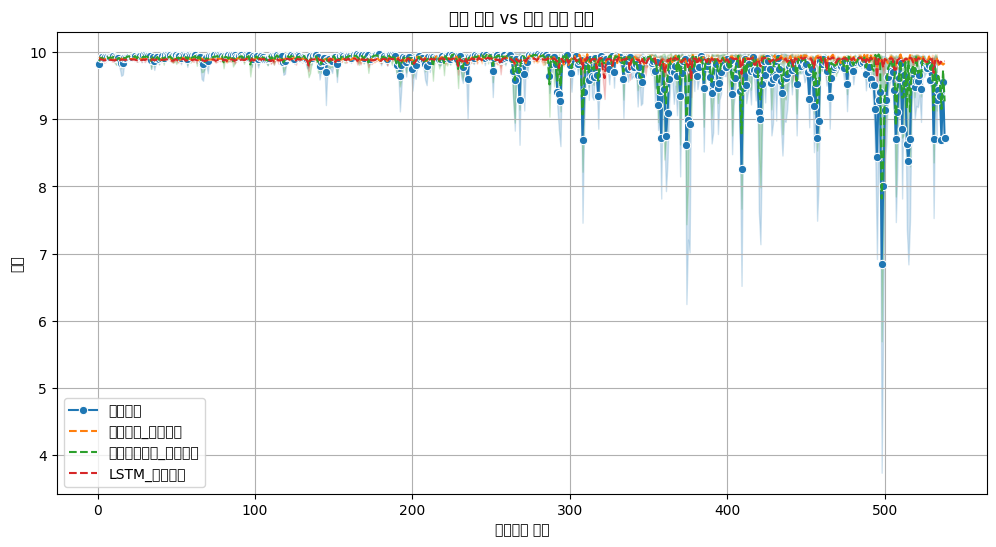

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from tabulate import tabulate

# CSV 파일 불러오기 (예측 결과 포함된 데이터)
df = pd.read_csv("prediction_all.csv")

# 실제 별점과 예측된 별점 비교
models = ["선형회귀_전체예측", "랜덤포레스트_전체예측", "LSTM_전체예측"]
results = {}

for model in models:
    mse = mean_squared_error(df["실제별점"], df[model])
    rmse = np.sqrt(mse)
    r2 = r2_score(df["실제별점"], df[model])
    results[model] = {"MSE": mse, "RMSE": rmse, "R²": r2}

# 결과 데이터프레임 생성
results_df = pd.DataFrame(results).T

# 성능 비교 출력
print("\n🔹 실제 별점 vs 예측 별점 성능 비교")
print(tabulate(results_df, headers="keys", tablefmt="pretty", floatfmt=".4f"))

# 시각화 - 실제 별점과 예측 별점 비교
plt.figure(figsize=(12, 6))
sns.lineplot(x=df["화번호"], y=df["실제별점"], label="실제별점", marker="o", linestyle="-")
for model in models:
    sns.lineplot(x=df["화번호"], y=df[model], label=model, linestyle="--")

plt.xlabel("에피소드 번호")
plt.ylabel("별점")
plt.title("실제 별점 vs 예측 별점 비교")
plt.legend()
plt.grid()
plt.show()


# **시각화 그래프: 에피소드 별 예측 평점 vs 실제 평점**

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

# 폰트 파일 경로 지정 및 폰트 추가
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [9]:
print("파일 내 존재하는 웹툰ID 목록:")
print(data_all_pred["웹툰"].unique())  # 웹툰ID 목록 출력

파일 내 존재하는 웹툰ID 목록:
[758037 822657 774866 654774 834886 822573 835736 821597 833255 769209
 747269 811721 797443 804862 807178 717481 812354 836052 800770 835206
 823285 813563 773797 735661 808389 765804 807777 823195 737628 821851
 836370 813454 814543 812594 817859 835030 818791 827190 834033 821953
 833620 814826 796075 602910 795297 783053 828715 819929 789979 747271
 746857 758150 776601 817246 777767 641253 799837 835116 725586 826670
 816798 721948 832677 779632 805193]


선택할 웹툰ID를 입력하세요: 758037
+-----+----------+--------+--------------------+--------------------+----------+-------------------+-----------------------+---------------+
|     |   웹툰   | 화번호 |      긍정비율      |      부정비율      | 실제별점 | 선형회귀_전체예측 | 랜덤포레스트_전체예측 | LSTM_전체예측 |
+-----+----------+--------+--------------------+--------------------+----------+-------------------+-----------------------+---------------+
| 181 | 758037.0 |  1.0   | 0.9878141522407532 | 0.0121858477592468 |   9.82   | 9.968393180285643 |   9.97000000000002    |   9.923339    |
| 180 | 758037.0 |  2.0   | 0.3315955281257629 | 0.668404471874237  |   9.76   | 9.747993158424434 |   9.396599999999994   |   9.730941    |
| 179 | 758037.0 |  3.0   | 0.8841912865638732 | 0.1158087134361267 |   9.54   | 9.933590020147806 |   9.963300000000018   |   9.909828    |
| 178 | 758037.0 |  4.0   | 0.4862357378005981 | 0.5137642621994019 |   9.8    | 9.79993119300692  |   9.824999999999994   |   9.842156    |
| 177 | 758037.0 |  5.0   | 

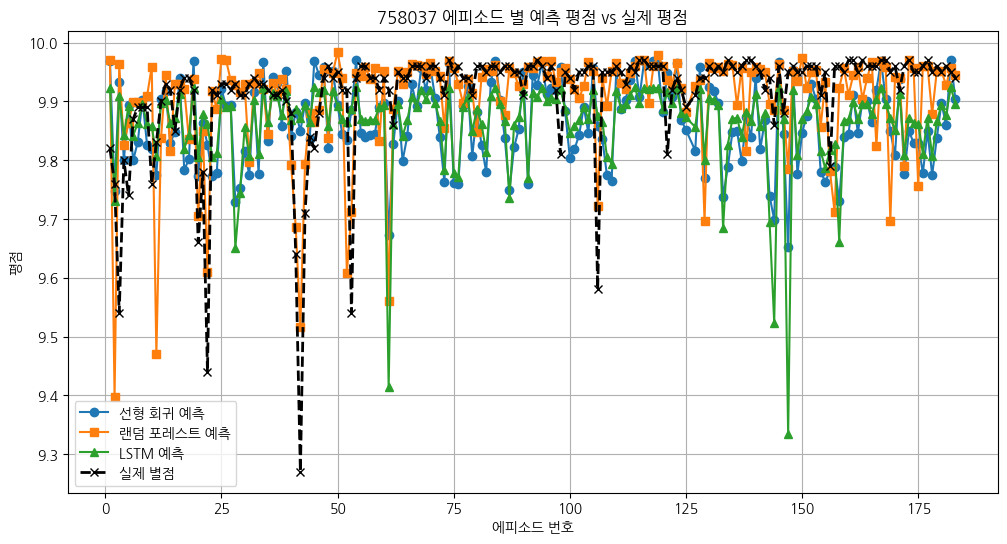

In [10]:
# CSV 파일 불러오기
data_all_pred = pd.read_csv("prediction_all.csv")

# 사용자 입력받기
selected_webtoon = int(input("선택할 웹툰ID를 입력하세요: "))

# 웹툰ID 필터링 (숫자로 변환)
webtoon_df = data_all_pred[data_all_pred['웹툰'] == selected_webtoon].copy()

# 화번호를 정수로 변환 후 정렬
webtoon_df = data_all_pred[data_all_pred['웹툰'] == selected_webtoon].copy()

# 화번호가 정수형이면 정렬 가능
if webtoon_df['화번호'].dtype == 'O':  # 'O'는 object(문자열) 타입
    webtoon_df['화번호'] = pd.to_numeric(webtoon_df['화번호'], errors='coerce')

webtoon_df = webtoon_df.sort_values(by='화번호')  # 화번호 기준 정렬

# 🔹 필터링 및 정렬된 데이터 확인
print(tabulate(webtoon_df.head(), headers="keys", tablefmt="pretty", floatfmt=".4f"))
plt.figure(figsize=(12, 6))

# 모델별 예측값 (선형 회귀, 랜덤 포레스트, LSTM)
plt.plot(webtoon_df['화번호'], webtoon_df['선형회귀_전체예측'], marker='o', label='선형 회귀 예측')
plt.plot(webtoon_df['화번호'], webtoon_df['랜덤포레스트_전체예측'], marker='s', label='랜덤 포레스트 예측')
plt.plot(webtoon_df['화번호'], webtoon_df['LSTM_전체예측'], marker='^', label='LSTM 예측')

# 실제 별점 (실제 값은 검은색 점선으로 표시)
plt.plot(webtoon_df['화번호'], webtoon_df['실제별점'], marker='x', linestyle='--',linewidth=2, color='black', label='실제 별점')

plt.xlabel("에피소드 번호")
plt.ylabel("평점")
plt.title(f"{selected_webtoon} 에피소드 별 예측 평점 vs 실제 평점")
plt.legend()
plt.grid(True)
plt.show()


선택할 웹툰ID를 입력하세요: 758037


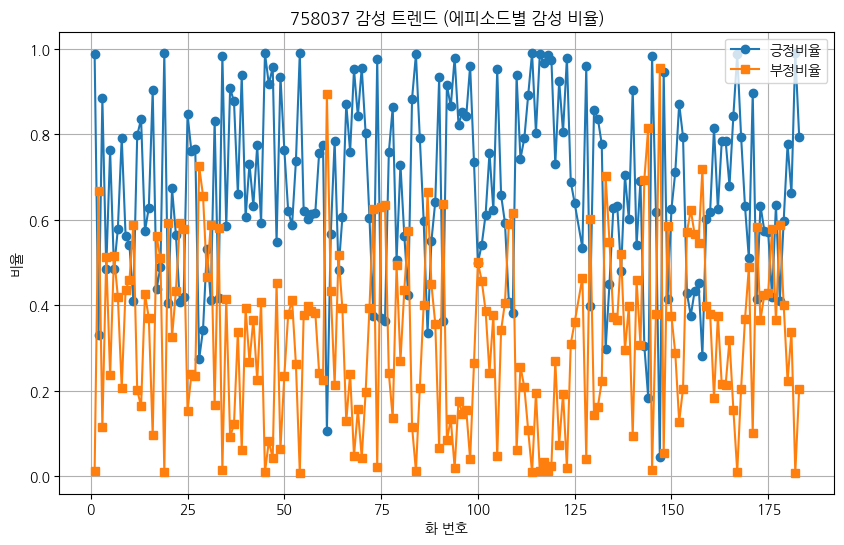

In [12]:
# -------------------------------------------
# A. 감성 트렌드 시계열 분석 (에피소드별 감성 비율 변화)
# -------------------------------------------
# 특정 웹툰 선택 (예: '웹툰1') 후, 에피소드별 감성 비율 변화 선 그래프

# CSV 파일 불러오기
data_all_pred = pd.read_csv("prediction_all.csv")

# 사용자 입력받기
selected_webtoon = int(input("선택할 웹툰ID를 입력하세요: "))

# 웹툰ID 필터링 (숫자로 변환)
webtoon_df = data_all_pred[data_all_pred['웹툰'] == selected_webtoon].copy()

# 화번호를 정수로 변환 후 정렬
webtoon_df = data_all_pred[data_all_pred['웹툰'] == selected_webtoon].copy()

# 화번호가 정수형이면 정렬 가능
if webtoon_df['화번호'].dtype == 'O':  # 'O'는 object(문자열) 타입
    webtoon_df['화번호'] = pd.to_numeric(webtoon_df['화번호'], errors='coerce')

webtoon_df = webtoon_df.sort_values(by='화번호')  # 화번호 기준 정렬


plt.figure(figsize=(10, 6))
plt.plot(webtoon_df['화번호'], webtoon_df['긍정비율'], marker='o', label='긍정비율')
plt.plot(webtoon_df['화번호'], webtoon_df['부정비율'], marker='s', label='부정비율')
plt.xlabel("화 번호")
plt.ylabel("비율")
plt.title(f"{selected_webtoon} 감성 트렌드 (에피소드별 감성 비율)")
plt.legend()
plt.grid(True)
plt.show()


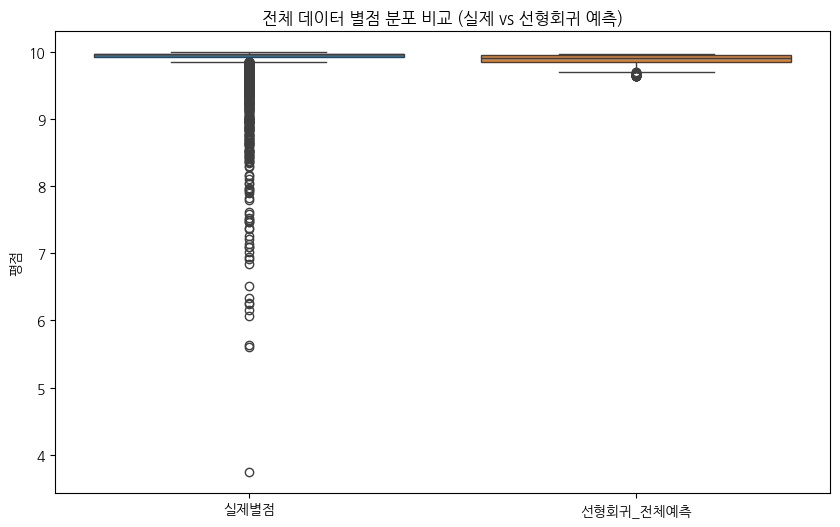

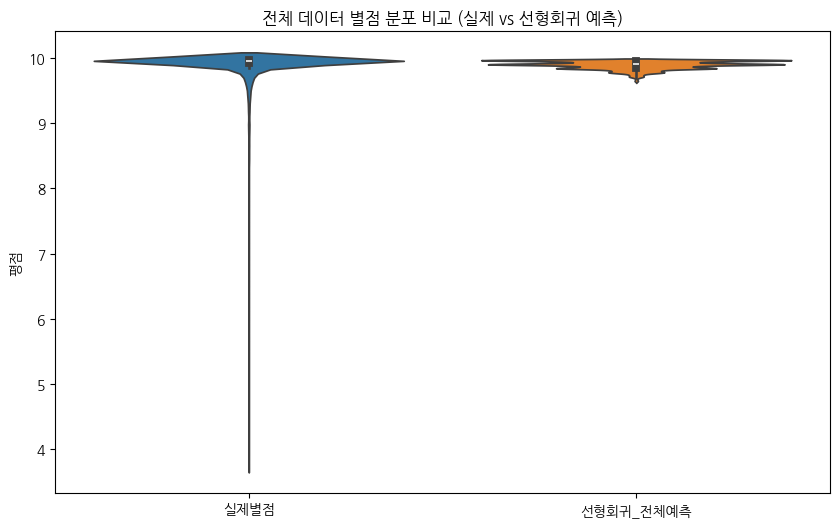

In [13]:
# -------------------------------------------
# B. 평점 분포 및 통계 비교 (박스 플롯 / 바이올린 플롯)
# -------------------------------------------
# 여기서는 전체 데이터에 대해 실제 별점과 선형 회귀 모델의 전체 예측값 분포를 비교합니다.
# 전체 데이터에 대해 선형 회귀 예측 수행 (이미 lr_model은 학습되었다고 가정)
# 만약 lr_model이 이미 학습된 상태라면:
all_pred_lr = lr_model.predict(data[['긍정비율', '부정비율']])

# 결과 DataFrame에 예측값 추가
data_all = data.copy()
data_all['선형회귀_전체예측'] = all_pred_lr

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_all[['실제별점', '선형회귀_전체예측']])
plt.title("전체 데이터 별점 분포 비교 (실제 vs 선형회귀 예측)")
plt.ylabel("평점")
plt.show()

# 또는 바이올린 플롯으로 분포 비교
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_all[['실제별점', '선형회귀_전체예측']])
plt.title("전체 데이터 별점 분포 비교 (실제 vs 선형회귀 예측)")
plt.ylabel("평점")
plt.show()

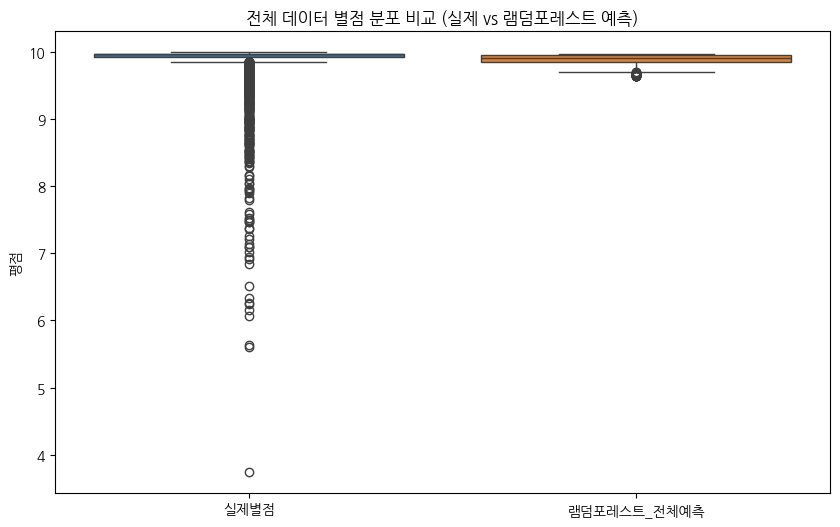

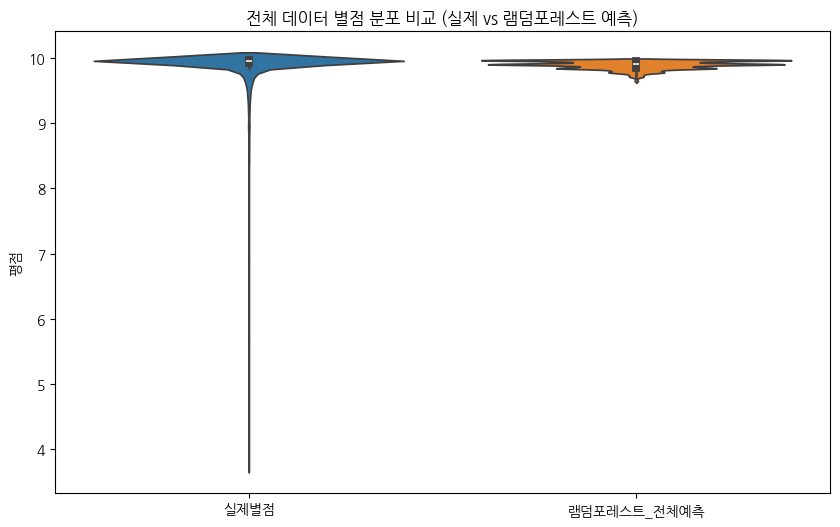

In [14]:
# -------------------------------------------
# B. 평점 분포 및 통계 비교 (박스 플롯 / 바이올린 플롯)
# -------------------------------------------
# 여기서는 전체 데이터에 대해 실제 별점과 랜덤포레스트 모델의 전체 예측값 분포를 비교합니다.
# 전체 데이터에 대해 랜덤포레스트 예측 수행 (이미 lr_model은 학습되었다고 가정)
# 만약 lr_model이 이미 학습된 상태라면:
all_pred_rf = lr_model.predict(data[['긍정비율', '부정비율']])

# 결과 DataFrame에 예측값 추가
data_all = data.copy()
data_all['램덤포레스트_전체예측'] = all_pred_rf

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_all[['실제별점', '램덤포레스트_전체예측']])
plt.title("전체 데이터 별점 분포 비교 (실제 vs 램덤포레스트 예측)")
plt.ylabel("평점")
plt.show()

# 또는 바이올린 플롯으로 분포 비교
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_all[['실제별점', '램덤포레스트_전체예측']])
plt.title("전체 데이터 별점 분포 비교 (실제 vs 램덤포레스트 예측)")
plt.ylabel("평점")
plt.show()

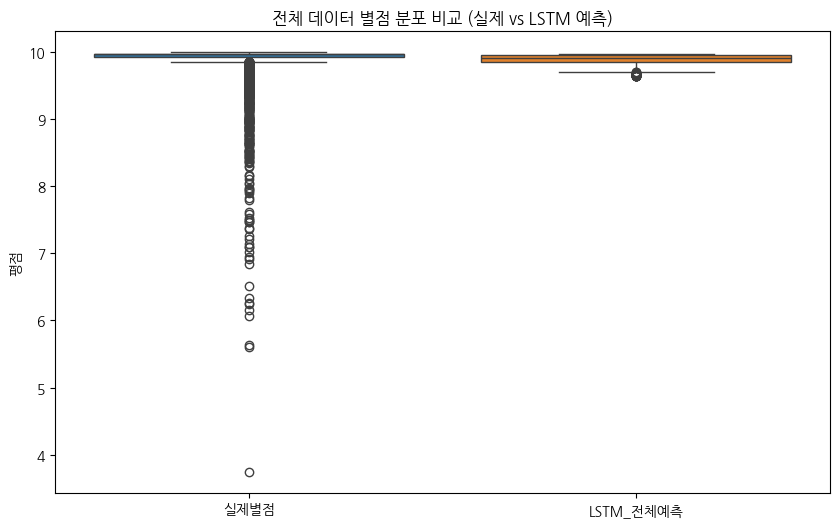

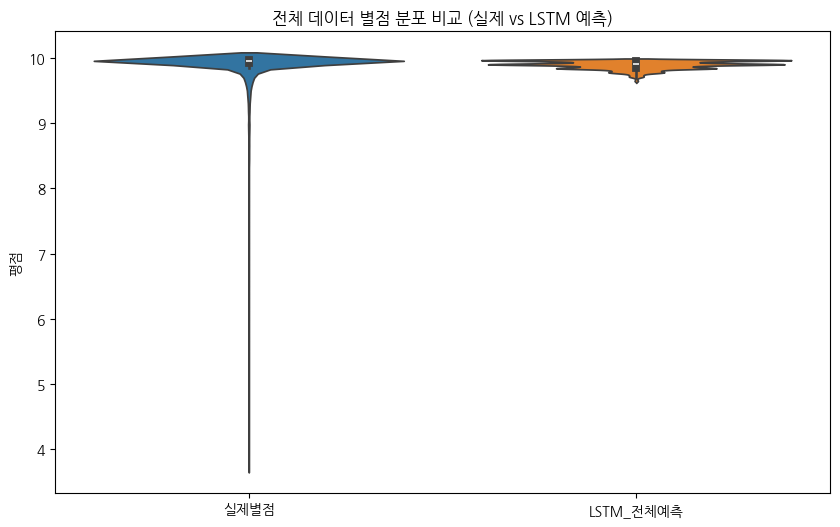

In [15]:
# -------------------------------------------
# B. 평점 분포 및 통계 비교 (박스 플롯 / 바이올린 플롯)
# -------------------------------------------
# 여기서는 전체 데이터에 대해 실제 별점과 LSTM 모델의 전체 예측값 분포를 비교합니다.
# 전체 데이터에 대해 LSTM 예측 수행 (이미 lr_model은 학습되었다고 가정)
# 만약 lr_model이 이미 학습된 상태라면:
all_pred_lstm = lr_model.predict(data[['긍정비율', '부정비율']])

# 결과 DataFrame에 예측값 추가
data_all = data.copy()
data_all['LSTM_전체예측'] = all_pred_lstm

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_all[['실제별점', 'LSTM_전체예측']])
plt.title("전체 데이터 별점 분포 비교 (실제 vs LSTM 예측)")
plt.ylabel("평점")
plt.show()

# 또는 바이올린 플롯으로 분포 비교
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_all[['실제별점', 'LSTM_전체예측']])
plt.title("전체 데이터 별점 분포 비교 (실제 vs LSTM 예측)")
plt.ylabel("평점")
plt.show()

선택할 웹툰ID를 입력하세요: 758037


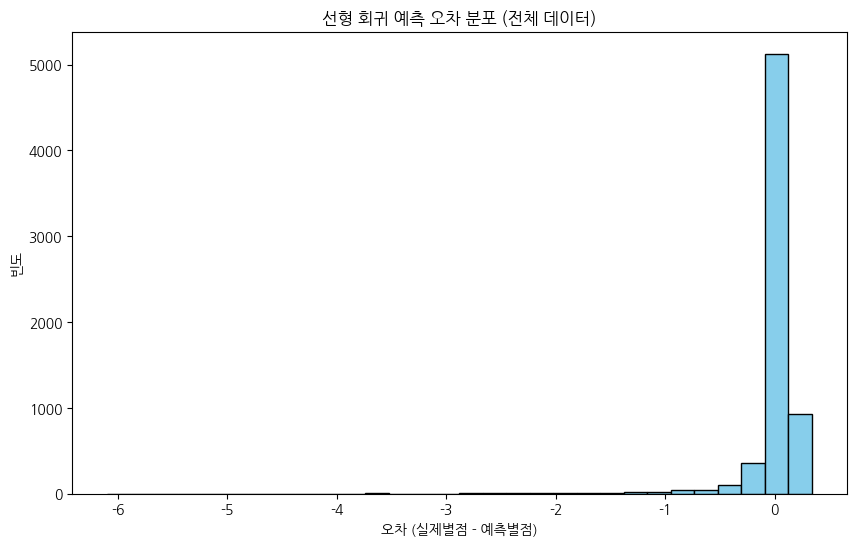

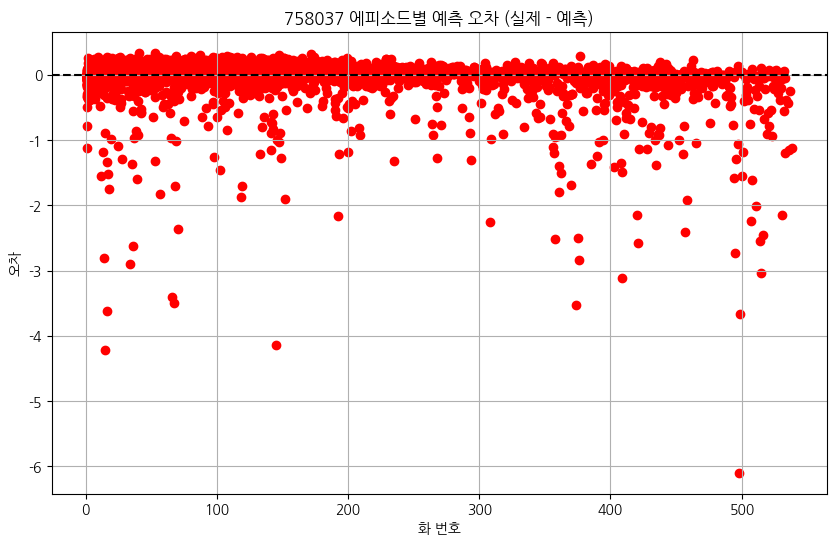

In [16]:
# -------------------------------------------
# C. 오차(Residual) 분석
# -------------------------------------------
# 여기서는 테스트셋에서 선형 회귀의 예측 오차를 분석한다고 가정 (comparison_df 사용)
# 만약 comparison_df가 이미 존재한다면, 오차를 계산하여 새로운 컬럼을 추가
# (오차 = 실제별점 - 예측별점)

# CSV 파일 불러오기
data_all_pred = pd.read_csv("prediction_all.csv")

# 사용자 입력받기
selected_webtoon = int(input("선택할 웹툰ID를 입력하세요: "))

# 웹툰ID 필터링 (숫자로 변환)
webtoon_df = data_all_pred[data_all_pred['웹툰'] == selected_webtoon].copy()

# 화번호가 정수형이면 정렬 가능
if webtoon_df['화번호'].dtype == 'O':  # 'O'는 object(문자열) 타입
    webtoon_df['화번호'] = pd.to_numeric(webtoon_df['화번호'], errors='coerce')

webtoon_df = webtoon_df.sort_values(by='화번호')  # 화번호 기준 정렬

# 오차 컬럼 추가 (오차 = 실제별점 - 예측별점)
data_all_pred['오차'] = data_all_pred['실제별점'] - data_all_pred['선형회귀_전체예측']

# 오차 분포 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(data_all_pred['오차'], bins=30, color='skyblue', edgecolor='black')
plt.title("선형 회귀 예측 오차 분포 (전체 데이터)")
plt.xlabel("오차 (실제별점 - 예측별점)")
plt.ylabel("빈도")
plt.show()

# 오차 산점도 (특정 웹툰에 대해)
plt.figure(figsize=(10, 6))
plt.scatter(data_all_pred['화번호'], data_all_pred['오차'], color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title(f"{selected_webtoon} 에피소드별 예측 오차 (실제 - 예측)")
plt.xlabel("화 번호")
plt.ylabel("오차")
plt.grid(True)
plt.show()

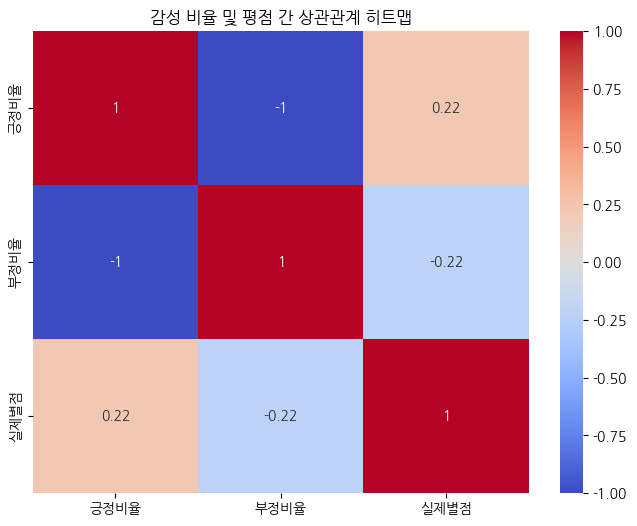

In [17]:
# -------------------------------------------
# D. 상관관계 히트맵 (감성 지표와 평점 간)
# -------------------------------------------
# 감성 비율 및 평점 관련 컬럼들의 상관관계 계산
corr_cols = ['긍정비율', '부정비율', '실제별점']
corr_matrix = data[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("감성 비율 및 평점 간 상관관계 히트맵")
plt.show()

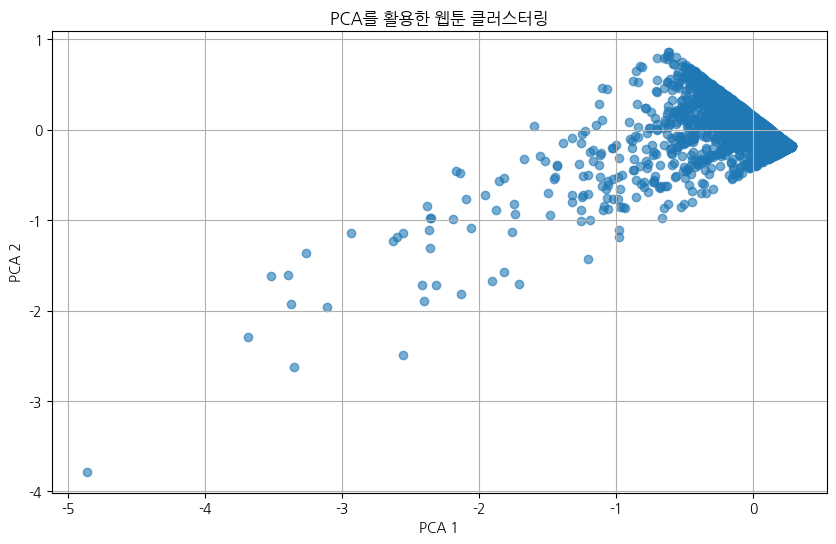

In [20]:
# -------------------------------------------
# F. 웹툰 클러스터링 및 차원 축소 시각화 (PCA)
# -------------------------------------------
# 감성 지표와 평점 데이터를 활용해 PCA 수행 후 장르별로 시각화
# 사용할 피처: '긍정비율', '부정비율', '중립비율', '평점', '실제별점'
from sklearn.decomposition import PCA

features = ['긍정비율', '부정비율', '실제별점']
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data[features])
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
# 장르별로 색상을 구분 (장르 컬럼이 존재한다고 가정)
if '장르' in data.columns:
    genres = data['장르'].unique()
    for genre in genres:
        subset = data[data['장르'] == genre]
        plt.scatter(subset['PCA1'], subset['PCA2'], label=genre, alpha=0.6)
    plt.legend()
    plt.title("PCA를 활용한 웹툰 클러스터링 (감성 및 평점 기반)")
else:
    plt.scatter(data['PCA1'], data['PCA2'], alpha=0.6)
    plt.title("PCA를 활용한 웹툰 클러스터링")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()